<a href="https://colab.research.google.com/github/hksantosh/eip/blob/master/tmp/PersonAttributes_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/EIP4/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive/  hvc_annotations.csv  resized/  sample_data/


In [2]:
%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from keras.applications import VGG16
from keras.layers.core import Dropout, Flatten, Dense
from keras.layers import Input, Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D
from keras.regularizers import l2
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

from keras.utils import plot_model

Using TensorFlow backend.


In [3]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [4]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [0]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=32, shuffle=True):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [6]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [7]:
train_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
9525,resized/9526.jpg,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0
4729,resized/4730.jpg,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0
9077,resized/9078.jpg,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0
6105,resized/6106.jpg,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0
11946,resized/11948.jpg,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0


In [8]:
val_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
6216,resized/6217.jpg,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0
630,resized/631.jpg,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0
3544,resized/3545.jpg,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0
4371,resized/4372.jpg,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0
13414,resized/13416.jpg,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0


In [9]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=64)
valid_gen = PersonDataGenerator(val_df, batch_size=64, shuffle=False)

len(train_gen), len(valid_gen)

(180, 31)

In [10]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [11]:
len(num_units), images.shape, targets.get('gender_output').shape, targets.get('age_output').shape

(8, (64, 224, 224, 3), (64, 2), (64, 5))

In [0]:
def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

def resnet_layer(inputs,
                 num_filters=32,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization(momentum=0.4)(x)
            x=Dropout(0.07)(x)
          #  x=Dropout(0.13)(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization(momentum=0.4)(x)
            x=Dropout(0.07)(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 32
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
   # x = AveragePooling2D(pool_size=4)(x)
    y = GlobalAveragePooling2D()(x)
    #outputs=Activation('softmax')(y)

    # heads
    neck = y
    gender = build_head("gender", neck)
    image_quality = build_head("image_quality", neck)
    age = build_head("age", neck)
    weight = build_head("weight", neck)
    bag = build_head("bag", neck)
    footwear = build_head("footwear", neck)
    emotion = build_head("emotion", neck)
    pose = build_head("pose", neck)

    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    #model = Model(inputs=inputs, outputs=outputs)
    model = Model(
        inputs=inputs, 
        outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
    )
    return model

In [0]:
def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 32
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [15]:
model = resnet_v1(input_shape=(224, 224, 3), depth=14, num_classes=len(num_units))












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



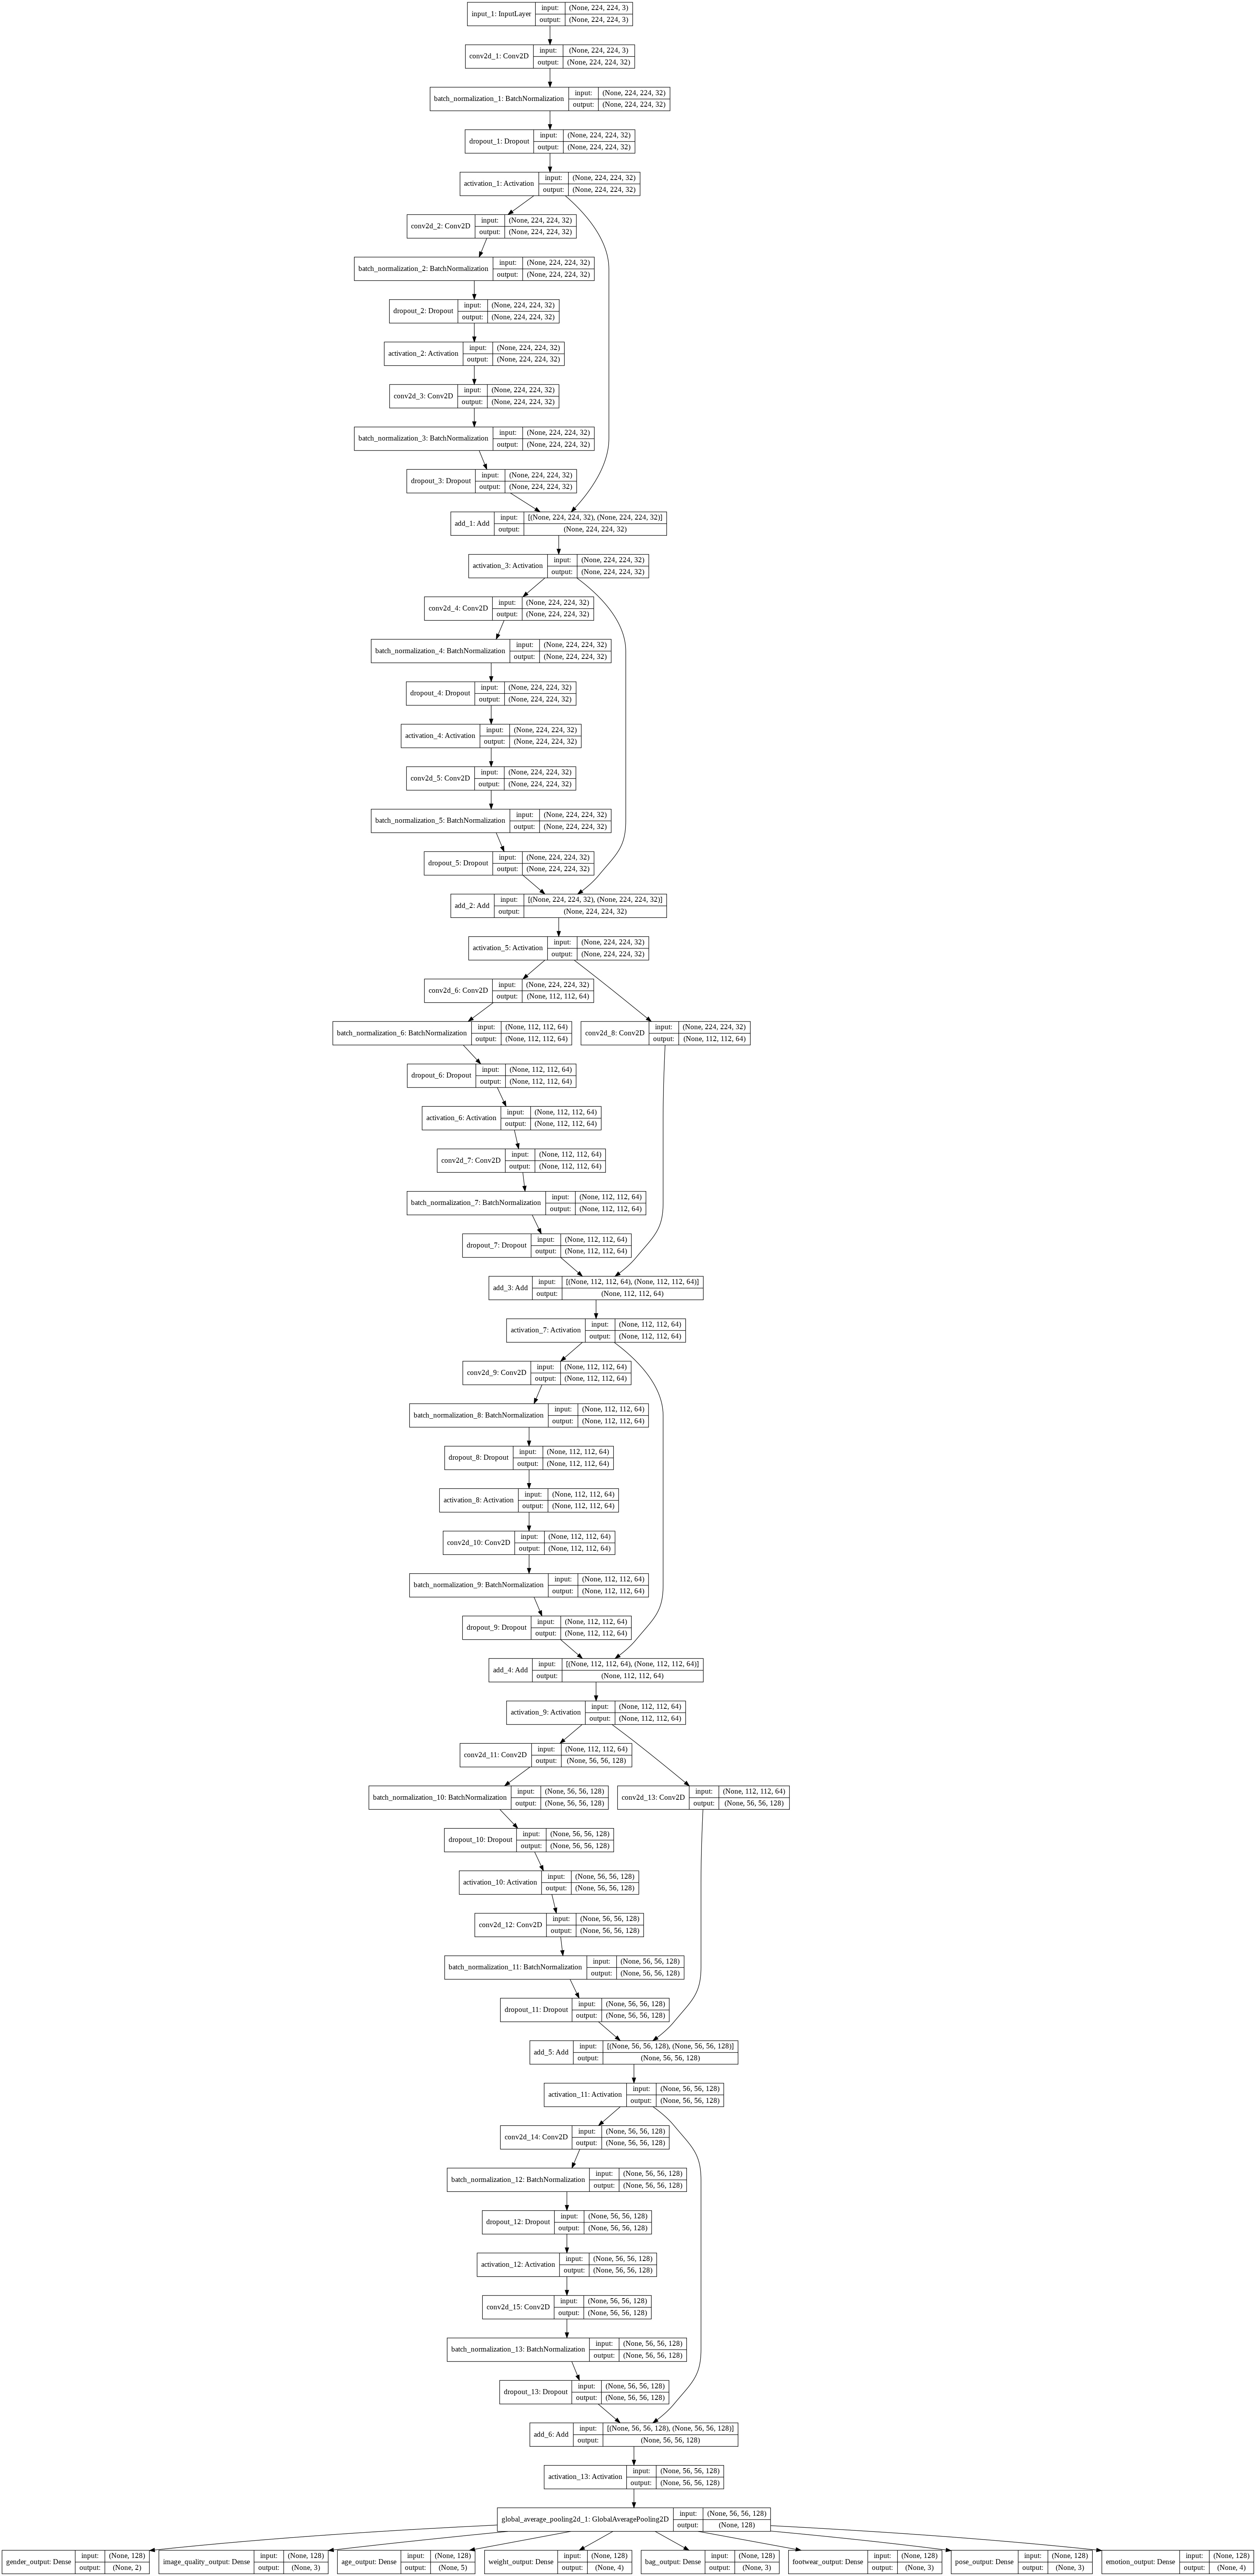

In [16]:
plot_model(model, show_shapes=True)

In [17]:
losses = {
 	"gender_output": "binary_crossentropy",
 	"image_quality_output": "categorical_crossentropy",
 	"age_output": "categorical_crossentropy",
 	"weight_output": "categorical_crossentropy",
 	"bag_output": "categorical_crossentropy",
 	"footwear_output": "categorical_crossentropy",
 	"pose_output": "categorical_crossentropy",
 	"emotion_output": "categorical_crossentropy"
}

loss_weights = {
    "gender_output": 1.0, "image_quality_output": 1.0, "age_output": 1.0, 
    "weight_output": 1.0, "bag_output": 1.0,  "footwear_output": 1.0,
    "pose_output": 1.0,  "emotion_output": 1.0
}

opt = SGD(lr=0.001, momentum=0.4)
model.compile(
    optimizer=opt,
#    loss='categorical_crossentropy',
    loss=losses,
    loss_weights=loss_weights,
    metrics=["accuracy"]
)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [18]:
model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=10,
    verbose=1
)



Epoch 1/10


ResourceExhaustedError: ignored

In [19]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 224, 224, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________